In [ ]:
pip install nilearn

Start: 2022-05-28 18:21:32
00:00:00 - Loading nifti done
00:00:17 - Downsampling nifti done
00:00:17 - Reset image orientation done
00:00:18 - WARNING - Diastole or systole could not be determined for "ct_test_2039_0000.nii.gz". Systole used as default
00:00:49 - Object detection done

Accuracy	8.935260136922201
Center x	66
Center y	37
Center z	54

Axial


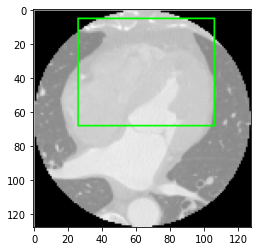

Sagittal


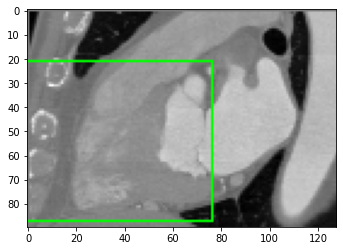

Coronal


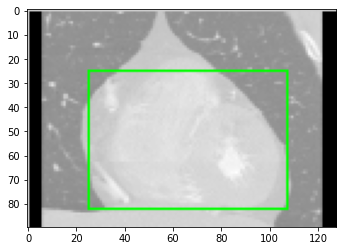


00:00:53 - cropping done
00:01:52 - All done


In [4]:
# 3D object detection for a single NIfTI file
import time 
import datetime
import numpy as np
import nibabel as nib
from nilearn.image import resample_img
from PIL import Image
import imgcompare as ic
import matplotlib
import matplotlib.pyplot as plt 
import cv2
import sys
import SimpleITK as sitk
import os # for doing directory operations
from os import path
import csv

DIR_INPUT    = 'C:\\Users\\Administrator\\OneDrive\\Thesis\\Coding\\Leon\\Heatmap_object_detection\\input\\ct_test\\'
DIR_OUTPUT   = 'C:\\Users\\Administrator\\OneDrive\\Thesis\\Coding\\Leon\\Heatmap_object_detection\\output\\ct_test\\'
DIR_REF      = 'C:\\Users\\Administrator\\OneDrive\\Thesis\\Coding\\Leon\\Heatmap_object_detection\\reference_imgs\\'
DIR_META     = 'C:\\Users\\Administrator\\OneDrive\\Thesis\\Coding\\Leon\\Heatmap_object_detection\\output\\metadata\\'
NIFTI        = 'ct_test_2039_0000.nii.gz'

def print_duration(msg):
    hours, rem = divmod(time.time()-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("{:0>2}:{:0>2}:{:0>2} - ".format(int(hours),int(minutes),int(seconds))+msg)
    
def save_metadata(original_nii):
    header_dict = original_nii.header
    line = NIFTI
    line_hdr = ''
    column_nr = 0
    for key in header_dict.keys():
        line_hdr = line_hdr+';'+str(header_dict.keys()[column_nr])
        line = line+';'+str(header_dict[key])
        column_nr += 1
    line = line.replace("\r\n","")
    line = line+'\r'
    
    if not path.exists(DIR_META+'ROI_metadata_NIfTI.csv'):
        with open(DIR_META+'ROI_metadata_NIfTI.csv', 'a') as roifile:
            roifile.write(line_hdr+'\r')
            roifile.write(line)
    else:
        with open(DIR_META+'ROI_metadata_NIfTI.csv', 'a') as roifile:
            roifile.write(line)
    
def read_nifti(filename):
    original_nii = nib.load(filename)
    save_metadata(original_nii)           
    voxelsize = original_nii.header.get_zooms()
    ratio = 0.16/voxelsize[0] # resize 512 to 128
    print_duration('Loading nifti done')

    if nib.aff2axcodes(original_nii.affine) != ('R', 'A', 'S'):
        sys.exit('ERROR - Change image orientation to LPI')
    if original_nii.shape[0] != 512 or original_nii.shape[1] != 512:
        sys.exit('ERROR - Image shape should be (512, 512, x)')
        
    # Resize 512*512*x to 128*128*x to improve processing time
    downsampled_nii = resample_img(original_nii, 
                                   target_affine=np.eye(3)*((voxelsize[0]*4.0324)+0.0007), 
                                   interpolation='nearest')
    if downsampled_nii.shape[0] != 128 or downsampled_nii.shape[1] != 128:
        print_duration(downsampled_nii.shape)
        sys.exit('ERROR - Image shape should be (128, 128, x)')
    else:
        print_duration('Downsampling nifti done')
    resampled = np.asanyarray(downsampled_nii.dataobj)
    
    # To comply with orientation in viewers such as ITK-Snap or 3D Slicer
    resampled = np.rot90(resampled, k=1, axes=(0, 2))
    resampled = np.flip(resampled, axis=1)
    resampled = np.flip(resampled, axis=2)
    print_duration('Reset image orientation done')

    ratio_1 = original_nii.shape[0]/downsampled_nii.shape[0]
    ratio_2 = original_nii.shape[1]/downsampled_nii.shape[1]
    ratio_3 = original_nii.shape[2]/downsampled_nii.shape[2]
    return resampled, ratio_1, ratio_2, ratio_3

def set_valid_values(arr):
    # Convert array to float32 with range of 0.0-1.0
    arrmin = np.amin(arr)
    arrmax = np.amax(arr)
    if arrmax-arrmin > 0:
        arr = np.float32((arr-arrmin)/(arrmax-arrmin))
    else:
        arr = np.float32(arr-arrmin)
    arr = np.clip(arr, a_min=0.0, a_max=1.0)
    return arr
        
def find_object(resampled, atlas_a, atlas_c, atlas_s):
    bestacc  = 999999
    best_x   = -1
    best_y   = -1
    best_z   = -1
    depth    = resampled.shape[0]
    height   = resampled.shape[1]
    width    = resampled.shape[2]
    acc3d    = np.zeros((height,width,depth), dtype=np.float32)
    acc3d1   = np.zeros((height,width,depth), dtype=np.uint8)

    # Axial
    atlas_a_h = np.array(atlas_a).shape[0]
    atlas_a_w = np.array(atlas_a).shape[1]
    i_y = (height-atlas_a_h)
    i_x = (width-atlas_a_w)
    if i_x <= 0:
        sys.exit('ERROR - reference images too large (Axial)')

    for iz in range(depth):
        if iz % 4 == 0:
            temp01 = set_valid_values(resampled[iz,:,:])
            tempimg = Image.fromarray(np.uint8(temp01 * 255) , 'L')
            for iy in range(i_y):
                if iy % 4 == 0:
                    for ix in range(i_x):
                        if ix % 4 == 0:
                            crop = tempimg.crop((0+ix, 0+iy, atlas_a_w+ix, atlas_a_h+iy))
                            acc = ic.image_diff_percent(atlas_a, crop)

                            d = iz-2
                            d = int(np.clip(d, a_min=0.0, a_max=depth))
                            d1 = d+4
                            if d==0:
                                d1 = d+2
                            elif d==depth:
                                d1 = depth

                            for i_d in range(d,d1):
                                h = int(iy+(atlas_a_h//2)-2)
                                for i_h in range(h,h+4):
                                    w = int(ix+(atlas_a_w//2)-2)
                                    for i_w in range(w,w+4):
                                        acc3d[i_h,i_w,i_d]+=acc
                                        acc3d1[i_h,i_w,i_d]+=1

    # Sagittal
    atlas_s_h = np.array(atlas_s).shape[0]
    atlas_s_w = np.array(atlas_s).shape[1]
    i_z = (depth-atlas_s_h)
    i_y = (height-atlas_s_w)
    if i_y <= 0:
        sys.exit('ERROR - reference images too large (Sagittal)')

    for ix in range(width):
        if ix % 4 == 0:
            temp01 = set_valid_values(resampled[:,:,ix])
            tempimg = Image.fromarray(np.uint8(temp01 * 255) , 'L')
            for iz in range(i_z):
                if iz % 4 == 0:
                    for iy in range(i_y):
                        if iy % 4 == 0:
                            crop = tempimg.crop((0+iy, 0+iz, atlas_s_w+iy, atlas_s_h+iz))
                            acc = ic.image_diff_percent(atlas_s, crop)

                            w = ix-2
                            w = int(np.clip(w, a_min=0.0, a_max=width))
                            w1 = w+4
                            if w==0:
                                w1 = w+2
                            elif w==width:
                                w1 = width

                            for i_w in range(w,w1):
                                h = int(iy+(atlas_s_w//2)-2)
                                for i_h in range(h,h+4):
                                    d = int(iz+(atlas_s_h//2)-2)
                                    for i_d in range(d,d+4):
                                        acc3d[i_h,i_w,i_d]+=acc
                                        acc3d1[i_h,i_w,i_d]+=1

    # Coronal
    atlas_c_h = np.array(atlas_c).shape[0]
    atlas_c_w = np.array(atlas_c).shape[1]
    i_z = (depth-atlas_c_h)
    i_x = (width-atlas_c_w)
    if i_z <= 0:
        sys.exit('ERROR - reference images too large (Coronal)')

    for iy in range(height):
        if iy % 4 == 0:
            temp01 = set_valid_values(resampled[:,iy,:])
            tempimg = Image.fromarray(np.uint8(temp01 * 255) , 'L')
            for iz in range(i_z):
                if iz % 4 == 0:
                    for ix in range(i_x):
                        if ix % 4 == 0:
                            crop = tempimg.crop((0+ix, 0+iz, atlas_c_w+ix, atlas_c_h+iz))
                            acc = ic.image_diff_percent(atlas_c, crop)

                            h = iy-2
                            h = int(np.clip(h, a_min=0.0, a_max=height))
                            h1 = h+4
                            if h==0:
                                h1 = h+2
                            elif h==height:
                                h1 = height

                            for i_h in range(h,h1):
                                w = int(ix+(atlas_c_w//2)-2)
                                for i_w in range(w,w+4):
                                    d = int(iz+(atlas_c_h//2)-2)
                                    for i_d in range(d,d+4):
                                        acc3d[i_h,i_w,i_d]+=acc
                                        acc3d1[i_h,i_w,i_d]+=1

    # Calculate best accuracy over all axis
    for d in range(depth):
        for h in range(height):
            for w in range(width):
                # Only measurements from all 3 axis are valid
                if acc3d1[h,w,d]==3:
                    if acc3d[h,w,d]<bestacc:
                        bestacc = acc3d[h,w,d]
                        best_x = w
                        best_y = h
                        best_z = d
                    
    return bestacc/3, best_x, best_y, best_z, atlas_a_w, atlas_a_h, atlas_s_w, atlas_s_h, atlas_c_w, atlas_c_h
    
def show_bbox(view, best_xmin, best_ymin, atlas_w, atlas_h, axis, side_a, side_b):
    print(view)
    color = (0, 255, 0)
    xmin = int(best_xmin-(atlas_w/2))
    xmax = xmin+atlas_w
    ymin = int(best_ymin-(atlas_h/2))
    ymax = ymin+atlas_h
    temp01 = set_valid_values(axis)
    # Change grayscale array with shape from (128,128) to color with shape (128,128,3)
    imgcolor = np.zeros((side_a,side_b,3), dtype=np.float32)
    imgcolor[:,:,0] = temp01*255
    imgcolor[:,:,1] = temp01*255
    imgcolor[:,:,2] = temp01*255
    cv2.rectangle(imgcolor, (xmin, ymin), (xmax, ymax), color, 1)
    plt.imshow(imgcolor.astype('uint8'))
    plt.show()
    
def create_roifile(inputdir, 
                   outputdir, 
                   filename,
                   best_x, 
                   best_y, 
                   best_z, 
                   atlas_a_h, 
                   atlas_a_w,
                   atlas_s_h,
                   atlas_s_w,
                   atlas_c_h,
                   atlas_c_w,
                   ratio_1,
                   ratio_2,
                   ratio_3,
                   correctie_z):
    reader         = sitk.ImageFileReader()
    reader.SetImageIO("NiftiImageIO")
    reader.SetFileName(filename)
    image          = reader.Execute()
    depth          = image.GetDepth()
    height         = image.GetHeight()
    width          = image.GetWidth()
    
    # Correction for a small misaligment along the Z-axis to prevent aorta cutoffs
    #best_z -= correctie_z

    # Add a small margin to prevent myocardium cutoffs, i.e. 1.05 or 1.1
    margin = 2.4

    # Get the height, width or depth of an ROI by calculating the average of reference image dimensions
    # Divide the result in two, for adding or subtracting to the centerpoint (best_x, best_y, best_z)
    # Calculate min and max coordinates, going from right to left, down to up, back to front
    # The input values are based on a cropped image. Multiply by the 'shrinkratio' so that the
    # coordinates can be used on the original full size image
    x2 = int(width - (best_x-(((atlas_a_w+atlas_c_w)*margin)/4))*ratio_1)
    x1 = int(width - (best_x+(((atlas_a_w+atlas_c_w)*margin)/4))*ratio_1)
    y2 = int(height - (best_y-(((atlas_a_h+atlas_s_h)*margin)/4))*ratio_2)
    y1 = int(height - (best_y+(((atlas_a_h+atlas_s_h)*margin)/4))*ratio_2)
    z2 = int(depth - (best_z-(((atlas_c_h+atlas_s_w)*margin)/4))*ratio_3)
    z1 = int(depth - (best_z+(((atlas_c_h+atlas_s_w)*margin)/4))*ratio_3)
    # Prevent ROI from overflowing the original image
    x1 = np.clip(x1, a_min=0, a_max=width)
    x2 = np.clip(x2, a_min=0, a_max=width)
    y1 = np.clip(y1, a_min=0, a_max=height)
    y2 = np.clip(y2, a_min=0, a_max=height)
    z1 = np.clip(z1, a_min=0, a_max=depth)
    z2 = np.clip(z2, a_min=0, a_max=depth)

    cropped_image = image[x1:x2,y1:y2,z1:z2]
    ##cropped_label = label[x1:x2,y1:y2,z1:z2]
    print_duration('cropping done')
    
    # Save image to disk
    output_file = os.path.join(DIR_OUTPUT, NIFTI.replace('image.nii.gz', '0000.nii.gz'))## changed for nnU-Net input requirements
    writer = sitk.ImageFileWriter()
    writer.SetFileName(output_file)
    writer.Execute(cropped_image)
    
    # Save label to disk
    ##output_label = os.path.join(DIR_OUTPUT, LABEL.replace('_label.nii.gz', '.nii.gz'))
    ##writer = sitk.ImageFileWriter()
    ##writer.SetFileName(output_label)
    ##writer.Execute(cropped_label)

start = time.time() 
dt = datetime.datetime.fromtimestamp(start).strftime('%Y-%m-%d %H:%M:%S') 
print('Start:',dt)

dia_a = Image.open(DIR_REF+'ct_test_2001_image.nii.gz A 34.jpg').convert('L') # Axial
dia_c = Image.open(DIR_REF+'ct_test_2001_image.nii.gz C 81.jpg').convert('L') # Coronal
dia_s = Image.open(DIR_REF+'ct_test_2001_image.nii.gz S 70.jpg').convert('L') # Sagittal
sys_a = Image.open(DIR_REF+'ct_test_2001_image.nii.gz A 34.jpg').convert('L') # Axial
sys_c = Image.open(DIR_REF+'ct_test_2001_image.nii.gz C 81.jpg').convert('L') # Coronal
sys_s = Image.open(DIR_REF+'ct_test_2001_image.nii.gz S 70.jpg').convert('L') # Sagittal

resampled, ratio_1, ratio_2, ratio_3 = read_nifti(DIR_INPUT+NIFTI)
if 'dia' in NIFTI:
    atlas_a = dia_a
    atlas_c = dia_c
    atlas_s = dia_s
    correctie_z = 15
elif 'sys' in NIFTI:
    atlas_a = sys_a
    atlas_c = sys_c
    atlas_s = sys_s
    correctie_z = 7
else:
    atlas_a = sys_a
    atlas_c = sys_c
    atlas_s = sys_s
    correctie_z = 15
    print_duration('WARNING - Diastole or systole could not be determined for "'+NIFTI+'". Systole used as default')
    
bestacc, best_x, best_y, best_z, atlas_a_w, atlas_a_h, atlas_s_w, atlas_s_h, atlas_c_w, atlas_c_h = find_object(resampled, 
                                                                                                                atlas_a, 
                                                                                                                atlas_c, 
                                                                                                                atlas_s)
print_duration('Object detection done')
print() 
print('Accuracy\t'+str(bestacc)) 
print('Center x\t'+str(best_x)) 
print('Center y\t'+str(best_y)) 
print('Center z\t'+str(best_z))
print()

depth = resampled.shape[0] 
height = resampled.shape[1] 
width = resampled.shape[2] 
show_bbox('Axial', best_x, best_y, atlas_a_w, atlas_a_h, resampled[best_z,:,:], height, width) 
show_bbox('Sagittal', best_y, best_z, atlas_s_w, atlas_s_h, resampled[:,:,best_x], depth, height) 
show_bbox('Coronal', best_x, best_z, atlas_c_w, atlas_c_h, resampled[:,best_y,:], depth, width) 
print()

create_roifile(DIR_INPUT, 
               DIR_OUTPUT, 
               DIR_INPUT+NIFTI,
               best_x, 
               best_y, 
               best_z,
               atlas_a_h, 
               atlas_a_w,
               atlas_s_h,
               atlas_s_w,
               atlas_c_h,
               atlas_c_w,
               ratio_1,
               ratio_2,
               ratio_3,
               correctie_z)

print_duration('All done')